In [62]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD,Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [63]:
# Kaggle API setup
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump({"username":"maxprodigy","key":"6d1fee4aa3c6b826476dbd37f1bf33f2"}, f)
!chmod 600 /root/.kaggle/kaggle.json

# Install and upgrade Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

# Download competition data
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir -p "/content/data"
!unzip -oq "assignment-1-time-series-forecasting-may-2025.zip" -d "/content/data

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists
assignment-1-time-series-forecasting-may-2025.zip: Skipping, found more recently modified local copy (use --force to force download)
/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [64]:
# Load the data
train = pd.read_csv("/content/train.csv")
print("Training data shape:", train.shape)
train.head()

Training data shape: (30676, 12)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [65]:
test = pd.read_csv('/content/test.csv')
print("Test data shape:", test.shape)
test.head()

Test data shape: (13148, 11)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [66]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [67]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

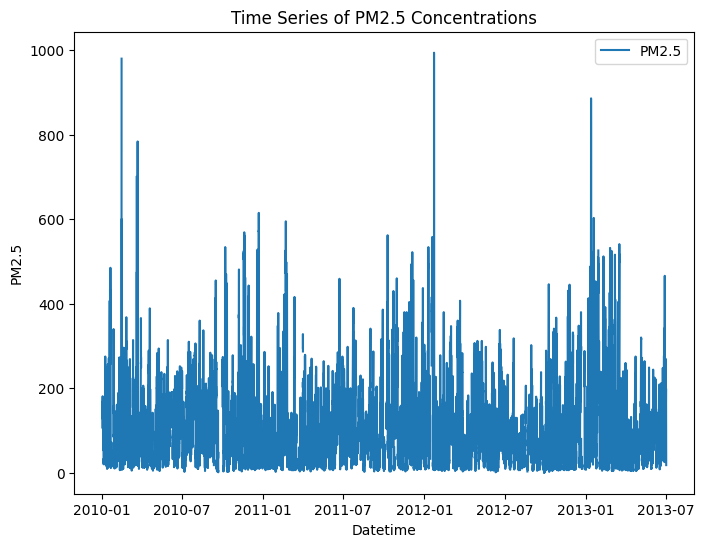

In [68]:
# Visualization: Time series trend for PM2.5
plt.figure(figsize=(8, 6))
# Plot using the DataFrame's index for datetime and access 'pm2.5' from df_train
plt.plot(train.index, train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [69]:
# Checking for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())


Missing values in training data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [70]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [71]:
# Prepare features and target
X_train = train.drop(['pm2.5', 'No'], axis=1).to_numpy()
y_train = train['pm2.5'].to_numpy()
X_test = test.drop(['No'], axis=1).to_numpy()

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))

In [72]:
# Define the sequence creation function
seq_length = 48
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences for training
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)

In [73]:
model = Sequential([
        LSTM(128, activation='tanh', input_shape=(seq_length, X_train_seq.shape[2]), return_sequences=True),
        BatchNormalization(),
        Dropout(0.02),
        LSTM(32, activation='tanh', return_sequences=True),
        Dropout(0.02),
        LSTM(32, activation='tanh'),
        Dropout(0.02),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001, weight_decay=1e-5),
    loss='mean_squared_error',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

In [75]:
 history = model.fit(
        X_train_seq, y_train_seq,
        epochs=35,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )

Epoch 1/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - lambda: 0.0692 - loss: 0.0839 - val_lambda: 0.0714 - val_loss: 0.0080
Epoch 2/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 60s 155ms/step - lambda: 0.0597 - loss: 0.0046 - val_lambda: 0.0705 - val_loss: 0.0075
Epoch 3/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - lambda: 0.0555 - loss: 0.0036 - val_lambda: 0.0707 - val_loss: 0.0081
Epoch 4/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 80s 150ms/step - lambda: 0.0560 - loss: 0.0037 - val_lambda: 0.0695 - val_loss: 0.0068
Epoch 5/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 83s 152ms/step - lambda: 0.0496 - loss: 0.0029 - val_lambda: 0.0692 - val_loss: 0.0073
Epoch 6/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - lambda: 0.0490 - loss: 0.0029 - val_lambda: 0.0681 - val_loss: 0.0065
Epoch 7/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 148ms/step - lambda: 0.0459 - loss: 0.0026 - val_lambda: 0.0688 - val_loss: 0.0071
Epoch 8/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - lambda: 0.0443 - loss: 0.0024 - val_lambda: 0.0700 - v

958/958 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step


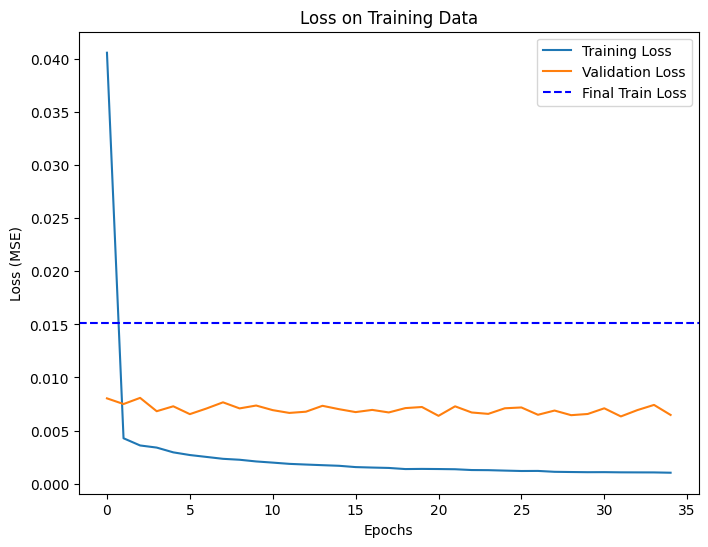

Final Training Loss (MSE): 0.015149567928363207
Final Training RMSE: 0.04184079217166998


In [76]:
train_predictions = model.predict(X_train_seq)
# Reshape train_predictions to match the shape of y_train_seq (30652,)
train_predictions_flat = train_predictions.flatten()

train_loss = np.mean((y_train_seq - train_predictions_flat) ** 2)
train_rmse = np.sqrt(mean_squared_error(y_train_seq, train_predictions_flat))

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training RMSE: {train_rmse}")

In [78]:
# Prepare test sequences without zeros
# Combine the last (seq_length-1) steps of training data with test data
X_combined_scaled = np.vstack((X_train_scaled[-(seq_length-1):], X_test_scaled))
n_test = len(X_test_scaled)

# Create sequences for test set
X_test_seq = []
for i in range(n_test):
    start_idx = i
    end_idx = i + seq_length
    X_test_seq.append(X_combined_scaled[start_idx:end_idx])
X_test_seq = np.array(X_test_seq)

# Verify the shape
print(f"X_test_seq shape: {X_test_seq.shape}")  # Should be (n_test, seq_length, n_features)

# Predict on test set
test_predictions_scaled = model.predict(X_test_seq)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled).flatten()
test_predictions = np.round(test_predictions).astype(int)

# Prepare submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_predictions
})

# Save submission file
submission.to_csv('/content/subm_fix3.csv', index=False)
print("Submission file saved successfully!")
print(submission.head())

X_test_seq shape: (13148, 48, 9)
411/411 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step
Submission file saved successfully!
               row ID  pm2.5
0  2013-07-02 4:00:00     19
1  2013-07-02 5:00:00     19
2  2013-07-02 6:00:00     19
3  2013-07-02 7:00:00     19
4  2013-07-02 8:00:00     19
